# **Fraud Detection using regression model**

#### **Project overview**
The Tunisian company of electricity and gaz (STEG) is a non-administrative company, it is responsible for delivering electricity and gaz across Tunisia.
The company sufferred tremendous losses in order of 200 million tunisian dinars due to fraudelant manipulations of meters by consumers.

in this project we will be using data gathered by the company (Clients billing/consumption history) to detect and recognize clients involved in fraudelent activities. 

####**Project structure** 
before start writing any code, first we need to understand the problem in details and set a some milestones to achieve in this project.

- Exploratory Data Analysis
  - downloading the data and converting it into a readable dataset
  - understanding the data 
  - Data preparation and cleaning
  - Deciding the features to build the model

- Model creation
  - Decide which type of Model fit to solve the problem in hand
  - Create the model based on input and output shape and the depth of model network
  - Create the model hyperparamater
  - create the training job 

- Visualizing and tuning
  - continue visualizing and tuning the hyperparamaters until we reach a optimized state
  - Model validation and testing

In [1]:
# For Python 2 / 3 compatability
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


#Load the dataset
we will be using the dataset provided to us by the ML academy via google drive. The following code cell download the data from google drive, loads it and then creates the following two pandas DataFrames:

*   train_df, which contains the training set

*   test_df, which contains the test set

In [5]:
#Downloading the train.zip file from the provided link https://drive.google.com/file/d/1DxxZ166bZ8MocyM210DODckm926xm4HJ/view?usp=sharing
!gdown --id '1DxxZ166bZ8MocyM210DODckm926xm4HJ'

#Downloading the test.zip file from the provided link https://drive.google.com/file/d/1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV/view?usp=sharing
!gdown --id '1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV'

Downloading...
From: https://drive.google.com/uc?id=1DxxZ166bZ8MocyM210DODckm926xm4HJ
To: /content/train.zip
100% 64.2M/64.2M [00:00<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV
To: /content/test.zip
100% 27.7M/27.7M [00:00<00:00, 53.7MB/s]


In [6]:
from zipfile import ZipFile
files = ['train.zip', 'test.zip']
export_path = "dataset/"
for f in files:
  zf = ZipFile(f, 'r')
  zf.extractall(export_path)
  zf.close()

## Exploratory Data Analysis

In [7]:
file_names = ['client_test', 'invoice_test', 'client_train', 'invoice_train']
data = {
    file_name: pd.read_csv(f'./dataset/{file_name}.csv') for file_name in file_names
}

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
data['client_train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [8]:
data['client_train'].describe()

,disrict,client_catg,region,target
count,135493.0,135493.0,135493.0,135493.0
mean,63.5,11.5,206.2,0.1
std,3.4,4.4,104.2,0.2
min,60.0,11.0,101.0,0.0
25%,62.0,11.0,103.0,0.0
50%,62.0,11.0,107.0,0.0
75%,69.0,11.0,307.0,0.0
max,69.0,51.0,399.0,1.0


The exploration of data types reveals that most columns have appropriate types, except for the client_id that should be set to a string and the creation date that should be transformed into a datetime. The description also show that there is no missing data in the dataset for all columns. The district and the client_catg seem to have very close values with a quantile having very close values.

Text(0.5, 1.0, 'The number of clients per region')

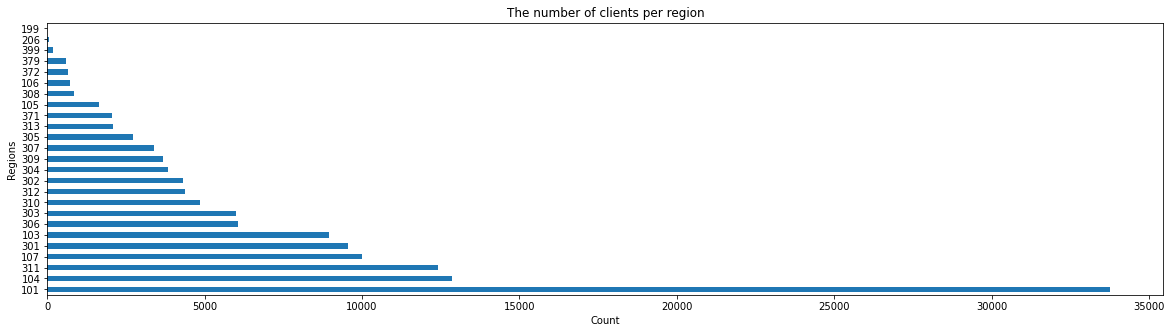

In [10]:
figure(figsize=(20,5))
data['client_train']['region'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Regions')
plt.title('The number of clients per region')

As it is clear in the plot, most of the clients are coming from the region 101. The clients are note uniformaly distributed cross regions and this may create bias in the final model.

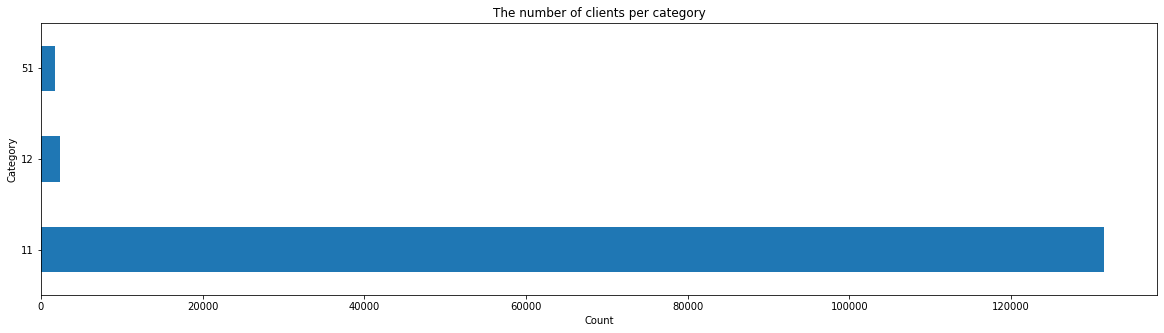

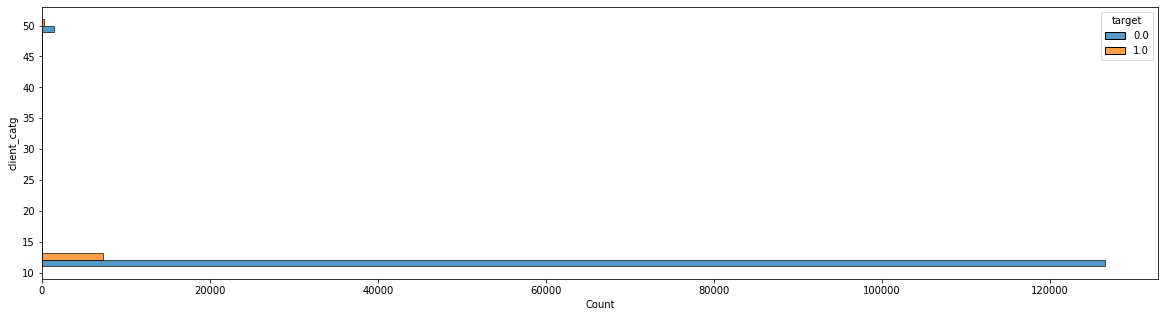

In [11]:
figure(figsize=(20,5))
data['client_train']['client_catg'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('The number of clients per category')
plt.show()
figure(figsize=(20,5))
sns.histplot(data['client_train'], y='client_catg', hue='target', multiple='dodge')
plt.show()

Furthermore, most of them are from gaterogy 11. This would maybe reveal that the category of the client will have a small effect on the predicted variable as it is most fo the time equal to 11.

Text(0.5, 1.0, 'The number of clients per district')

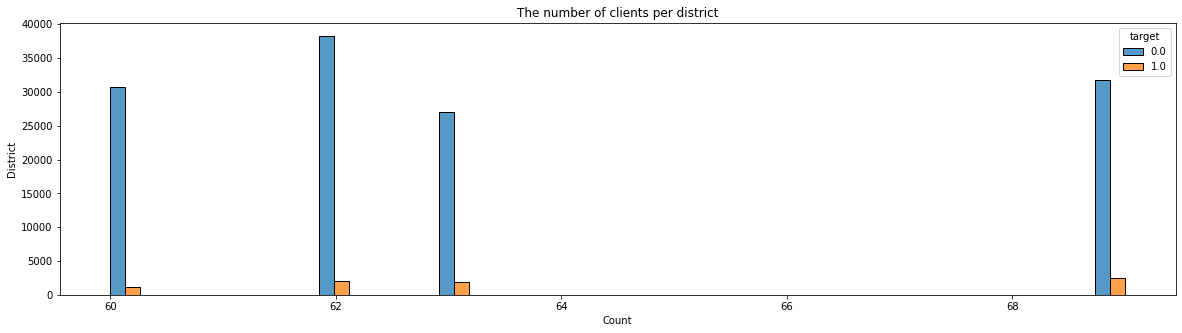

In [12]:
figure(figsize=(20,5))
sns.histplot(data['client_train'], x='disrict', hue='target', multiple='dodge')

plt.xlabel('Count')
plt.ylabel('District')
plt.title('The number of clients per district')

It is intersting to see that the  districts have approximately the same number of clients. 

In [13]:
data['invoice_train']

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [14]:
# check the distribution of the target variable
data['client_train']['target'].value_counts()

0.0    127927
1.0      7566
Name: target, dtype: int64

In [15]:
print("The pourcentage of fraudulent client in the dataset is :{:.2f}%".format(100*data['client_train']['target'].sum() / data['client_train'].shape[0]))

The pourcentage of fraudulent client in the dataset is :5.58%


##Data cleaning and merging

In [16]:
def clean_train_data(client_df, invoice_df):
    """
    A function that performs data cleaning for the client and invoice dataset
    
    :param client_df:
    :param invoice_df:
    :return:
    """

    #extract only useful column for training
    df = invoice_df[['client_id',  'consommation_level_1', 'consommation_level_2',
                   'consommation_level_3','consommation_level_4','reading_remarque',
                     'counter_type']].groupby('client_id').mean()
    invoice_df['consumption_per_month'] = invoice_df[[ 
                     'consommation_level_1', 
                     'consommation_level_2',
                   'consommation_level_3', 
                     'consommation_level_4']].sum(axis=1)
    
    invoice_df['consumption_per_month'] = invoice_df['consumption_per_month'] / invoice_df['months_number'] 
   
    df['consumption_per_month'] = invoice_df.groupby('client_id').mean()['consumption_per_month']
    df = df.drop(columns=['consommation_level_1', 'consommation_level_2','consommation_level_3', 'consommation_level_4'])

    client_df = client_df.drop(columns=['creation_date'])

    return df.merge(client_df,  on='client_id')

In [17]:
# using the implemented function for clean the training data
train_data = clean_train_data(data['client_train'], data['invoice_train'])
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   client_id              135493 non-null  object 
 1   reading_remarque       135493 non-null  float64
 2   consumption_per_month  135493 non-null  float64
 3   disrict                135493 non-null  int64  
 4   client_catg            135493 non-null  int64  
 5   region                 135493 non-null  int64  
 6   target                 135493 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 8.3+ MB


,client_id,reading_remarque,consumption_per_month,disrict,client_catg,region,target
0,train_Client_0,7.0,82.5,60,11,101,0.0
1,train_Client_1,7.2,129.4,69,11,107,0.0
2,train_Client_10,7.1,127.0,62,11,301,0.0
3,train_Client_100,6.2,0.3,69,11,105,0.0
4,train_Client_1000,8.9,237.9,62,11,303,0.0


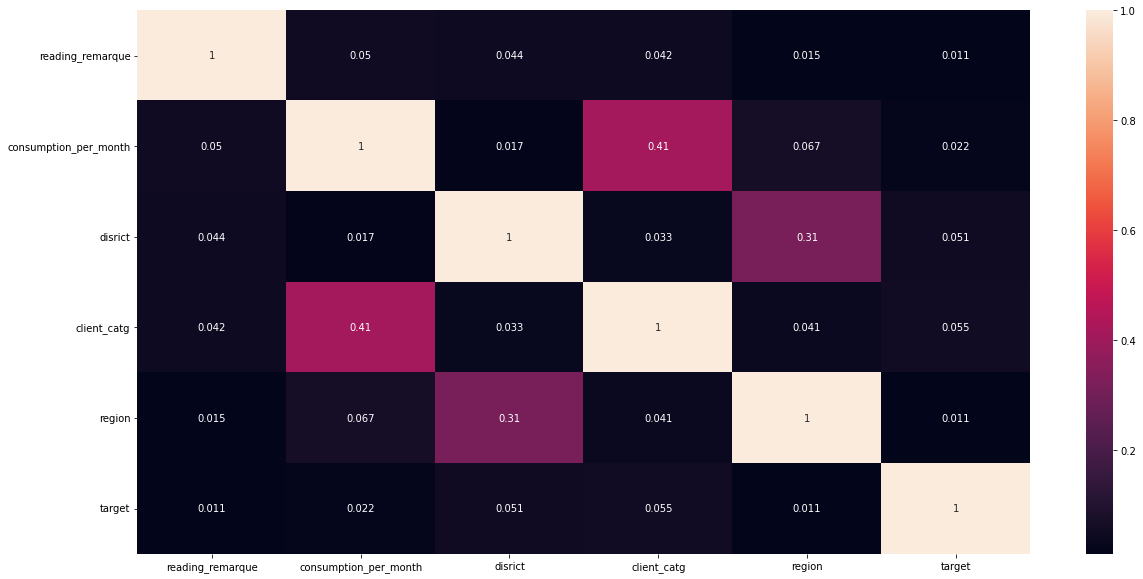

In [18]:
figure(figsize=(20,10))
sns.heatmap(train_data.corr().abs(), annot=True)

In [21]:
# split the dataset into the training set and test set
X_train = train_data.drop(['client_id','target'], axis=1)
y_train = train_data['target']

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import lightgbm
from lightgbm import LGBMClassifier

# build the lightgbm model
model = LGBMClassifier(boosting_type='gbdt',num_iteration=100000)

#Fit to training data
%time model.fit(X_train,y_train)

In [ ]:
test_data = clean_train_data(data['client_test'], data['invoice_test'])
X_test = test_data.drop(['client_id'], axis=1)

In [ ]:
y_pred = model.predict(X_test)
y_pred.mean()